In [1]:
# Imporing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Task 1.
**Loading and Exploring the Dataset** :
The first task is to load the dataset containing historical ride data. Take a look at the structure of the data, examine the features, and gain insights into the variables that may influence the fare amount. 

In [2]:
#Loading dataset
df=pd.read_csv('uber.csv')

Exploring the data

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.shape

(200000, 9)

Task 2 
**Handling Missing Data**

In [5]:
# checking for null values
df.isna().sum().sort_values(ascending=False)

dropoff_longitude    1
dropoff_latitude     1
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
passenger_count      0
dtype: int64

In [6]:
# As there are only 2 rows with null value so droping them will not effect our analysis
df=df.dropna()

In [7]:
df.shape

(199999, 9)

In [8]:
df.isna().sum().sum()

0

In [9]:
# Exploring the column fare_amount
df['fare_amount'].describe()

count    199999.000000
mean         11.359892
std           9.901760
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [10]:
# The minimum value of -52.00 suggests there may be outliers or data entry errors in the dataset, as fares are generally non-negative. 

In [11]:
# Making all fare amounts positive
df['fare_amount'] = df['fare_amount'].abs()

In [12]:
df['fare_amount'].describe()

count    199999.000000
mean         11.362780
std           9.898445
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

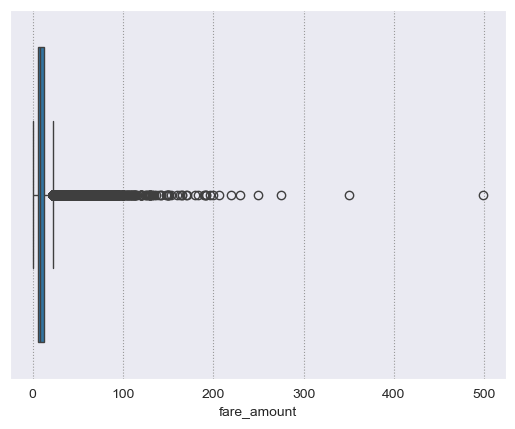

In [13]:
# checking for outliers in the dataset
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.boxplot(data=df,x='fare_amount')
plt.show()

In [14]:
# using IQR Method for Outliers
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]

In [15]:
df.shape

(182839, 9)

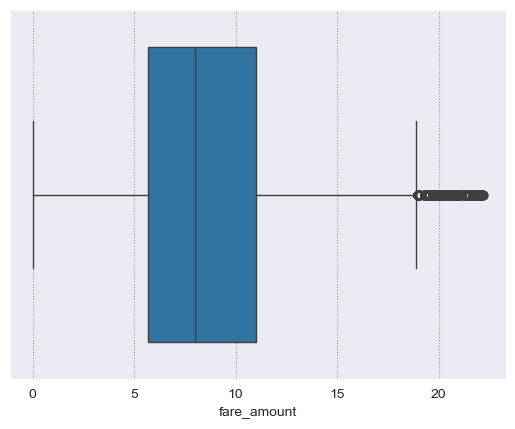

In [16]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.boxplot(data=df,x='fare_amount')
plt.show()

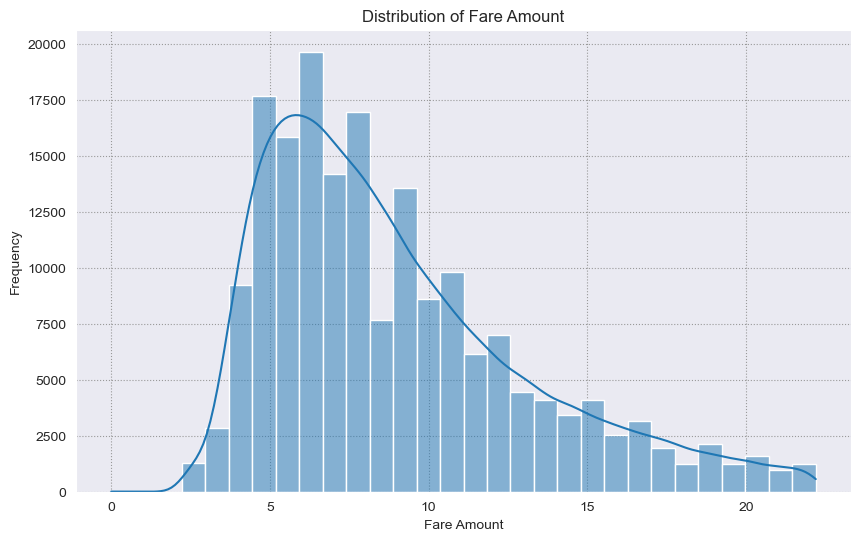

In [17]:
# Undestanding distribution of fare_amount
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=30, kde=True)
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

In [18]:
# histogram shows that data is skewed right

Task 3 
**Feature Engineering**

In [19]:
df = df[(df['pickup_latitude']  >= -90) & (df['pickup_latitude'] <= 90)]

In [20]:
df = df[(df['dropoff_latitude']  >= -90) & (df['dropoff_latitude'] <= 90)]

In [21]:
df.shape

(182834, 9)

In [22]:
# calculating the haversine distance between pickup and drop-off points
from geopy.distance import geodesic
import pandas as pd

# Defining the function to calculate distance
def calculate_distance(row):
    try:
        pickup = (row['pickup_latitude'], row['pickup_longitude'])
        dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
        return geodesic(pickup, dropoff).kilometers
    except Exception as e:
        print(f"Error calculating distance for row {row.name}: {e}")
        return None  # Return None for rows with errors

# Checking for missing data in critical columns
df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

# Appling the function and calculate distance
df['distance_km'] = df.apply(calculate_distance, axis=1)

In [23]:
# Extracting hour of day, day of the week, month, and year from the pickup datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])  # Ensure datetime format
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

In [24]:
# Creating a binary feature to indicate if the ride happened during rush hours (e.g., 7–9 AM and 4–7 PM). Fares may be higher during these periods.
def is_rush_hour(hour):
    return 1 if (7 <= hour <= 9) or (16 <= hour <= 19) else 0

df['rush_hour'] = df['hour'].apply(is_rush_hour)

In [25]:
# Creating a binary indicator for whether the trip occurred on a holiday
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max())
df['holiday'] = df['pickup_datetime'].dt.date.isin(holidays.date).astype(int)

In [26]:
# Create a binary feature indicating whether the ride occurred on a weekend
df['weekend'] = df['pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)

In [27]:
# Creating feature fare per kilometer to capture any anomalies or consistency in pricing across trips
df['fare_per_km'] = df['fare_amount'] / df['distance_km']

In [28]:
# Exploring new columns
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,day_of_week,month,year,rush_hour,holiday,weekend,fare_per_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.681111,19,3,5,2015,1,0,0,4.461336
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.454363,20,4,7,2009,0,0,0,3.137270
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.039603,21,0,8,2009,0,0,0,2.559726
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661442,8,4,6,2009,1,0,0,3.190001
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.483730,17,3,8,2014,1,0,0,3.568457


In [29]:
# Removing infinity values from dataset
df= df.replace([np.inf, -np.inf], np.nan)

In [31]:
df['fare_per_km'] = df['fare_per_km'].fillna(df['fare_per_km'].mean())

Task 4 
**Split the Dataset**

In [32]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['fare_amount','Unnamed: 0','pickup_datetime','key'])
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,day_of_week,month,year,rush_hour,holiday,weekend,fare_per_km
131495,0.000000,0.000000,0.000000,0.000000,5,0.000000,19,2,9,2013,1,0,0,15.370831
183988,-73.966353,40.799533,-73.974270,40.784830,1,1.764199,11,5,9,2011,0,0,1,3.004196
178251,-73.969762,40.763371,-73.958264,40.764284,1,0.976111,9,0,5,2014,1,0,0,8.708026
10748,-74.005059,40.741572,-73.975334,40.757750,1,3.086987,3,4,1,2011,0,0,0,2.753494
78705,-73.992173,40.759276,-73.992014,40.738286,1,2.330958,9,2,3,2014,1,0,0,5.791609


Task 5
**Data Scaling/Normalization**

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
num_cols=[col for col in X_train.columns]
scaler=StandardScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,day_of_week,month,year,rush_hour,holiday,weekend,fare_per_km
131495,6.591585,-6.524091,6.900014,-6.551669,2.350674,-0.050855,0.841276,-0.540486,0.795832,0.699351,1.380282,-0.143247,-0.628923,-0.000834
183988,-0.130398,0.143207,-0.137081,0.140111,-0.482049,-0.045990,-0.386622,1.004367,0.795832,-0.380185,-0.724490,-0.143247,1.590019,-0.025269
178251,-0.130708,0.137297,-0.135558,0.136740,-0.482049,-0.048164,-0.693597,-1.570389,-0.366041,1.239119,1.380282,-0.143247,-0.628923,-0.013999
10748,-0.133916,0.133735,-0.137182,0.135668,-0.482049,-0.042342,-1.614521,0.489416,-1.527913,-0.380185,-0.724490,-0.143247,-0.628923,-0.025764
78705,-0.132745,0.136628,-0.138769,0.132475,-0.482049,-0.044427,-0.693597,-0.540486,-0.946977,1.239119,1.380282,-0.143247,-0.628923,-0.019761


Task 6 
**Correlation Analysis**

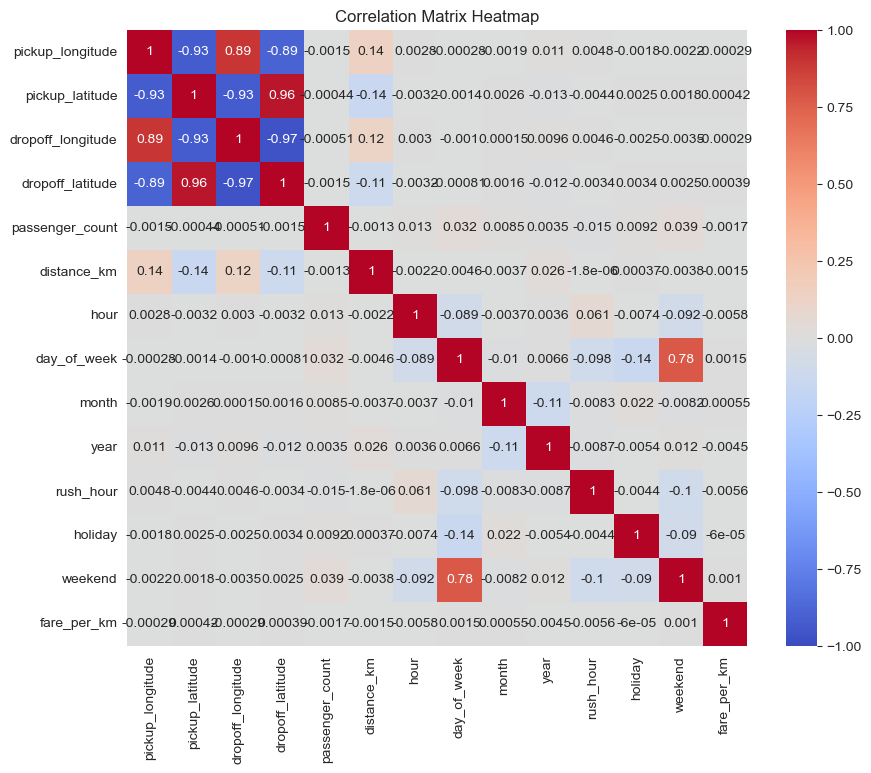

In [40]:
# Visualizing the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()